In [1]:
using Revise
using QuantumGraining
using QuantumCumulants
using Symbolics
using OrdinaryDiffEq
using ModelingToolkit
using Plots

# Time-coarse grained Rabi model

To demonstrate the use of the method, we start with a simple but illustrative example -- the Rabi model. The Rabi model describes the interaction of a single field mode interacting with a two-level system. However, unlike the Jaynes-Cummings model, it does not assume the rotating-wave approximation (RWA). More concretely, the model is described by the following Hamiltonian terms in the interaction picture,

$$
    \begin{align*}
    &g_{\Omega}
    =
    \{\frac{g}{2}, \frac{g}{2}, \frac{g}{2}, \frac{g}{2}\} \\
    &h_{\Omega}
    =
    \{\hat{a}\hat{\sigma}_-, \hat{a}^\dagger \hat{\sigma}_+, \hat{a}\hat{\sigma}_+, \hat{a}^\dagger \hat{\sigma_-} \} \\
    &\Omega
    =
    \{
    \omega_c + \omega_a,
    - \big( \omega_c + \omega_a \big),
    \omega_c - \omega_a,
    - \omega_c + \omega_a
    \} \\
    &\hat{H} = \sum_{\omega \in \Omega} g_\omega h_\omega e^{-i\omega t}
\end{align*}
$$

We start by coding in the Hamiltonian. We use `QuantumCumulants` to handle the operator algebra, a `Symbolics` for handling the symbolic calculations.

In [3]:
@variables g ωc ωa t τ
Ω = [ωc + ωa, - ωc - ωa, ωc - ωa, - ωc + ωa]
gvec = (g//2).*[1, 1, 1, 1]

# Hilbert space definitions
h_cav = FockSpace(:cavity)
h_atom = NLevelSpace(:atom, (:g,:e))
h = tensor(h_cav, h_atom)

# Operator definitions
@qnumbers a::Destroy(h) σ::Transition(h)
σm = σ(:g, :e)
σp = σ(:e, :g)
σz = σ(:e, :e) - σ(:g, :g)
σee = σ(:e, :e)
hvec = [a*σm, a'*σp, a*σp, a'*σm]

4-element Vector{QuantumCumulants.QMul{Nothing}}:
 (a*σge)
 (a′*σeg)
 (a*σeg)
 (a′*σge)

## First-order time-coarse graining - the JC model

To first-order the corrections are only Hermitian, and depend on a single contraction coefficient.

$$
    C_{1,0}(\omega) = e^{- \frac{\omega^2 \tau^2}{2}}
$$

We can calculate the first-order by hand, and compare it to the results obtained by `QuantumGraining.jl`. For brevity, let us denote,
$$
    \overline{\omega} = \omega_c + \omega_a \rightarrow \hat{a} \hat{\sigma}_- \\
    \Delta = \omega_c - \omega_a \rightarrow \hat{a} \sigma_+
$$

Collecting the relevant corrections,
$$
    \overline{\omega}: \ \ \ g_{a \sigma_-} = \frac{g}{2} e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0 \\
    \Delta: \ \ \ g_{a \sigma_+} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2} \\
    -\Delta: \ \ \ g_{a^{\dagger} \sigma_-} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2}\\
    -\overline{\omega}: \ \ \ g_{a^{\dagger} \sigma_+} = e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0
$$
which approximately gives the RWA Hamiltonian (it would be given directly for a cutoff filter).
$$
    H^{(1)} = \frac{g}{2} \left ( \hat{a}^\dagger \hat{\sigma}_- e^{i\Delta t} + \hat{a}\sigma_+ e^{-i\Delta t}\right )
$$



Equivalently, let us also do that by calling the `effective_hamiltonian_term` function, which calculates a single order of the TCG Hamiltonian.

In [4]:
#ops_eff_1, g_eff_1, Ω_eff_1 = effective_hamiltonian_term(hvec, gvec, Ω, 1)

# We can also call `effective_hamiltonian`, which gives the full Hamiltonian to a given order.
# To first order these are the same.
g_eff_1, Ω_eff_1 = effective_hamiltonian(hvec, gvec, Ω, 1; as_dict=true)

(Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient}((a′*σeg) => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2)), (a*σge) => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2)), (a′*σge) => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2)), (a*σeg) => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))), Dict{QuantumCumulants.QMul{Nothing}, Num}((a′*σeg) => -ωa - ωc, (a*σge) => ωa + ωc, (a′*σge) => ωa - ωc, (a*σeg) => -ωa + ωc))

In [5]:
g_eff_1

Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient} with 4 entries:
  (a′*σeg) => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a*σge)  => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a′*σge) => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a*σeg)  => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))

In [6]:
Ω_eff_1

Dict{QuantumCumulants.QMul{Nothing}, Num} with 4 entries:
  (a′*σeg) => -ωa - ωc
  (a*σge)  => ωa + ωc
  (a′*σge) => ωa - ωc
  (a*σeg)  => -ωa + ωc

In [7]:
@variables g ωc ωa t τ

5-element Vector{Num}:
  g
 ωc
 ωa
  t
  τ

In [8]:
using Test

Now we test the 1st-order TCG effective Hamiltonian

In [9]:
# a*σm: -ωa - ωc
begin
    @test isequal(length(g_eff_1[a*σm].exponents), 1)
    @test isequal(g_eff_1[a*σm].prefacs[1]*g_eff_1[a*σm].polys[1], [g//2])
    @test isequal(g_eff_1[a*σm].exponents[1], (ωa + ωc)^2)
    @test isequal(Ω_eff_1[a*σm], ωa + ωc)
end

# a'*σp: ωc + ωa
begin
    @test isequal(length(g_eff_1[a'*σp].exponents), 1)
    @test isequal(g_eff_1[a'*σp].prefacs[1]*g_eff_1[a'*σp].polys[1], [g//2])
    @test isequal(g_eff_1[a'*σp].exponents[1], (- ωc - ωa)^2)        
    @test isequal(Ω_eff_1[a'*σp], - ωc - ωa)
    end

# a*σp: ωa - ωc
begin
    @test isequal(length(g_eff_1[a*σp].exponents), 1)
    @test isequal(g_eff_1[a*σp].prefacs[1]*g_eff_1[a*σp].polys[1], [g//2])
    @test isequal(g_eff_1[a*σp].exponents[1], (- ωa + ωc)^2)    
    @test isequal(Ω_eff_1[a*σp], - ωa + ωc)
end

# a'*σm: ωc - ωa
begin
    @test isequal(length(g_eff_1[a'*σm].exponents), 1)
    @test isequal(g_eff_1[a'*σm].prefacs[1]*g_eff_1[a'*σm].polys[1], [g//2])
    @test isequal(g_eff_1[a'*σm].exponents[1], (- ωc + ωa)^2)    
    @test isequal(Ω_eff_1[a'*σm], - ωc + ωa)
end

Test Passed

To visualize the result, it is useful to use the `symbolic_hamiltonian` function, which renders the Hamiltonian in Latex.

In [10]:
@variables t τ  # define symbolic variables for displaying
H_1 = sum(symbolic_hamiltonian(g_eff_1, Ω_eff_1, t, τ))

(0.5g*exp(im*t*(ωa + ωc))*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*(a′*σeg)+0.5g*exp(im*t*(-ωa - ωc))*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*(a*σge)+0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*exp(im*t*(-ωa + ωc))*(a′*σge)+0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*exp(im*t*(ωa - ωc))*(a*σeg))

The results are a little bit hard to read, since they include also high-frequency terms weighted by the Gaussian filter. We can simplify the comparison to the RWA by replacing the Gaussian filter by a cutoff filter.

Since $\omega_c$ and $\omega_a$ are just symbols, we need to give them a value to decide whether an expression is high-frequency or not.

In [11]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
Ω_low_1 = drop_high_freqs(Ω_eff_1, freqs_subs)

Dict{QuantumCumulants.QMul{Nothing}, Num} with 2 entries:
  (a′*σge) => ωa - ωc
  (a*σeg)  => -ωa + ωc

With that, we can drop the high-frquency terms using `drop_high_freqs`. We can also call the function `gaussian_to_cutoff` to remove completely any high-frequency terms.

In [12]:
g_low_1 = gaussian_to_cutoff(g_eff_1, Ω_low_1, freqs_subs; keep_small_exponents=false)

Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient} with 2 entries:
  (a′*σge) => 0.5g
  (a*σeg)  => 0.5g

In [13]:
H_low_1 = sum(symbolic_hamiltonian(g_low_1, Ω_low_1, t, τ))

(0.5g*exp(im*t*(-ωa + ωc))*(a′*σge)+0.5g*exp(im*t*(ωa - ωc))*(a*σeg))

which is exactly the RWA Hamiltonian.

## Second-order time-coarse graining

To second-order, this we have two contraction coefficients.
$$
    C_{2,0}(\omega, \omega') = -C_{1,1}(\omega, \omega') = f(\omega, \omega') \\
    f(\omega, \omega') = \frac{1}{\omega'} \left [ e^{-\frac{\omega^2 + \omega'^2}{2}\tau^2} - e^{-\frac{(\omega + \omega')^2\tau^2}{2}} \right ]
$$

where we also have the following symmetries,
$$
    f(\omega, \omega') = \frac{\omega}{\omega'} f(\omega', \omega) \\
    f(\omega, -\omega') = -f(\omega, \omega')
$$

### Hamiltonian contributions

In [14]:
g_eff_2, Ω_eff_2 = effective_hamiltonian(hvec, gvec, Ω, 2; as_dict=true)

(Dict{Any, ContractionCoefficient}((a′*a′) => (0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (ωa^2 - (ωc^2)), (a′*a) => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa - 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (2(ωa^2) - 2(ωc^2)), (a′*σeg) => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2)), (a*σge) => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2)), (a′*a′*σee) => (-8.0(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa + 8.0(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (16.0(ωa^2) - 16.0(ωc^2)), (a*σeg) => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2)), (a*a) => (0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (ωa^2 - (ωc^2)), (a′*a*σee) => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*

In [15]:
g_eff_2

Dict{Any, ContractionCoefficient} with 11 entries:
  (a′*a′)     => (0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*ex…
  (a′*a)      => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^…
  (a′*σeg)    => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a*σge)     => 0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a′*a′*σee) => (-8.0(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa + 8.0(g^2)*exp…
  (a*σeg)     => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a*a)       => (0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*ex…
  (a′*a*σee)  => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^…
  σee         => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^…
  (a′*σge)    => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a*a*σee)   => (-2.0(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa + 2.0(g^2)*exp…

In [16]:
Ω_eff_2

Dict{Any, Num} with 11 entries:
  (a′*a′)     => -2ωc
  (a′*a)      => 0
  (a′*σeg)    => -ωa - ωc
  (a*σge)     => ωa + ωc
  (a′*a′*σee) => -2ωc
  (a*σeg)     => -ωa + ωc
  (a*a)       => 2ωc
  (a′*a*σee)  => 0
  σee         => 0
  (a′*σge)    => ωa - ωc
  (a*a*σee)   => 2ωc

Now we test the 2nd-order TCG effective Hamiltonian

In [17]:
# σee: 0
TestExpSigmaEE = [0, (ωa + ωc)^2 + (-ωa - ωc)^2, (ωa - ωc)^2 + (-ωa + ωc)^2]
TestPrefacSigmaEE = [[(g^2//4)*(1/(ωa - ωc) + 1/(ωa + ωc))],
[(-(g^2//4)/(ωa + ωc))],
[(-(g^2//4)/(ωa - ωc))]
]

3-element Vector{Vector{Num}}:
 [(1//4)*(g^2)*(1 / (ωa + ωc) + 1 / (ωa - ωc))]
 [((-1//4)*(g^2)) / (ωa + ωc)]
 [((-1//4)*(g^2)) / (ωa - ωc)]

In [18]:
begin
    @test isequal(Ω_eff_2[σee], 0)

    @test isequal(length(g_eff_2[σee].exponents), 3)

    for i in 1:3
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                g_eff_2[σee].prefacs[i].*g_eff_2[σee].polys[i][j]
                -
                TestPrefacSigmaEE[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(g_eff_2[σee].exponents[i], TestExpSigmaEE[i])
    end
end

In [19]:
# a*a*σee: 2*ωc
TestExpAASigmaEE = [(4//1)*(ωc^2), (ωa + ωc)^2 + (-ωa + ωc)^2]
TestPrefacAASigmaEE = [[(g^2//2)*ωa/((ωa - ωc)*(ωa + ωc))],
[-(g^2//2)*ωa/((ωa - ωc)*(ωa + ωc))]
]

2-element Vector{Vector{Num}}:
 [((g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]
 [(-(g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]

In [20]:
begin
    @test isequal(Ω_eff_2[a*a*σee], 2*ωc)

    @test isequal(length(g_eff_2[a*a*σee].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                g_eff_2[a*a*σee].prefacs[i].*g_eff_2[a*a*σee].polys[i][j]
                -
                TestPrefacAASigmaEE[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(g_eff_2[a*a*σee].exponents[i], TestExpAASigmaEE[i])
    end
end

In [21]:
# a'*a'σee: -2*ωc
TestExpAdAdSigmaEE = [(4//1)*(ωc^2), (ωa - ωc)^2 + (-ωa - ωc)^2]
TestPrefacAdAdSigmaEE = [[(g^2//2)*ωa/((ωa - ωc)*(ωa + ωc))],
[-(g^2//2)*ωa/((ωa - ωc)*(ωa + ωc))]
]

2-element Vector{Vector{Num}}:
 [((g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]
 [(-(g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]

In [22]:
begin
    @test isequal(Ω_eff_2[a'*a'*σee], -2*ωc)

    @test isequal(length(g_eff_2[a'*a'*σee].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                g_eff_2[a'*a'*σee].prefacs[i].*g_eff_2[a'*a'*σee].polys[i][j]
                -
                TestPrefacAdAdSigmaEE[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(g_eff_2[a'*a'*σee].exponents[i], TestExpAdAdSigmaEE[i])
    end
end

In [23]:
# a'*a*σee: 0
TestExpAdASigmaEE = [0, (ωa + ωc)^2 + (-ωa - ωc)^2, (ωa - ωc)^2 + (-ωa + ωc)^2]
TestPrefacAdASigmaEE = [[(g^2)*ωa/((ωa - ωc)*(ωa + ωc))],
[-(g^2//2)*1/(ωa + ωc)],
[-(g^2//2)*1/(ωa - ωc)]
]

3-element Vector{Vector{Num}}:
 [((g^2)*ωa) / ((ωa + ωc)*(ωa - ωc))]
 [((-1//2)*(g^2)) / (ωa + ωc)]
 [((-1//2)*(g^2)) / (ωa - ωc)]

In [24]:
begin
    @test isequal(Ω_eff_2[a'*a*σee], 0)

    @test isequal(length(g_eff_2[a'*a*σee].exponents), 3)

    for i in 1:3
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                g_eff_2[a'*a*σee].prefacs[i].*g_eff_2[a'*a*σee].polys[i][j]
                -
                TestPrefacAdASigmaEE[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(g_eff_2[a'*a*σee].exponents[i], TestExpAdASigmaEE[i])
    end
end

In [25]:
# a*a: 2*ωc
TestExpAA = [(4//1)*(ωc^2), (ωa + ωc)^2 + (-ωa + ωc)^2]
TestPrefacAA = [[-(g^2//4)*ωa/((ωa - ωc)*(ωa + ωc))],
[(g^2//4)*ωa/((ωa - ωc)*(ωa + ωc))]
]

2-element Vector{Vector{Num}}:
 [(-(g^2)*ωa) / (4(ωa + ωc)*(ωa - ωc))]
 [((g^2)*ωa) / (4(ωa + ωc)*(ωa - ωc))]

In [26]:
begin
    @test isequal(Ω_eff_2[a*a], 2*ωc)

    @test isequal(length(g_eff_2[a*a].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                g_eff_2[a*a].prefacs[i].*g_eff_2[a*a].polys[i][j]
                -
                TestPrefacAA[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(g_eff_2[a*a].exponents[i], TestExpAA[i])
    end
end

In [27]:
# a'*a': -2*ωc
TestExpAdAd = [(4//1)*(ωc^2), (ωa - ωc)^2 + (-ωa - ωc)^2]
TestPrefacAdAd = [[-(g^2//4)*ωa/((ωa - ωc)*(ωa + ωc))],
[(g^2//4)*ωa/((ωa - ωc)*(ωa + ωc))]
]

2-element Vector{Vector{Num}}:
 [(-(g^2)*ωa) / (4(ωa + ωc)*(ωa - ωc))]
 [((g^2)*ωa) / (4(ωa + ωc)*(ωa - ωc))]

In [28]:
begin
    @test isequal(Ω_eff_2[a'*a'], -2*ωc)

    @test isequal(length(g_eff_2[a'*a'].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                g_eff_2[a'*a'].prefacs[i].*g_eff_2[a'*a'].polys[i][j]
                -
                TestPrefacAdAd[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(g_eff_2[a'*a'].exponents[i], TestExpAdAd[i])
    end
end

In [29]:
# a'*a: 0
TestExpAdA = [0, (ωa + ωc)^2 + (-ωa - ωc)^2, (ωa - ωc)^2 + (-ωa + ωc)^2]
TestPrefacAdA = [[-(g^2//2)*ωa/((ωa - ωc)*(ωa + ωc))],
[(g^2//4)*1/(ωa + ωc)],
[(g^2//4)*1/(ωa - ωc)]
]

3-element Vector{Vector{Num}}:
 [(-(g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]
 [((1//4)*(g^2)) / (ωa + ωc)]
 [((1//4)*(g^2)) / (ωa - ωc)]

In [30]:
begin
    @test isequal(Ω_eff_2[a'*a], 0)

    @test isequal(length(g_eff_2[a'*a].exponents), 3)

    for i in 1:3
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                g_eff_2[a'*a].prefacs[i].*g_eff_2[a'*a].polys[i][j]
                -
                TestPrefacAdA[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(g_eff_2[a'*a].exponents[i], TestExpAdA[i])
    end
end

Most terms vanish simply due to the operators falling outside of the two-level manifold, i.e. $\hat{\sigma}_{\pm} \hat{\sigma}_{\pm} = 0$. The surviving terms would correspond to the following frequnecy pairs $\{ (\overline{\omega}, \Delta), (\overline{\omega}, -\overline{\omega}), (\Delta, -\Delta), (-\overline{\omega}, -\Delta) \}$, as well as their conjugates.

The coupling strengths are related to the contraction coefficients by the following symmetries,
$$
    g(\omega, -\omega) = f(\omega, -\omega) + f(\omega, -\omega) = 2f(\omega, -\omega) \\
    g(-\omega, \omega) = f(-\omega, \omega) + f(-\omega, \omega) = -2f(\omega, -\omega) \\
    g(\omega, -\omega) = -g(-\omega, \omega)
$$

The coupling strengths are calculated directly from the contraction coefficients and are given by,
$$
    g_{\overline{\omega}, \Delta} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\

    g_{\overline{\omega}, -\overline{\omega}} = \frac{2}{\overline{\omega}} \left [ e^{-\overline{\omega}^2 \tau^2} - 1 \right ] \approx - \frac{2}{\overline{\omega}} \\

    g_{\Delta, -\Delta} = \frac{2}{\Delta} \left [ e^{-\Delta^2 \tau^2} - 1\right ] \approx -2\tau^2 \Delta \\

    g_{\Delta, -\overline{\omega}} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\
$$

We can again compare with the coefficients obtained using `QuantumGraining.jl`. We first look at the frequencies of the different terms, as well as the different coupling corresponding to them.

In [31]:
to_symbol(g_eff_2[σee], τ)

(-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa - 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (-2(ωa^2) + 2(ωc^2))

In [32]:
to_symbol.(values(g_eff_2), τ)

11-element Vector{Num}:
             (0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (ωa^2 - (ωc^2))
 (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa - 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (2(ωa^2) - 2(ωc^2))
              0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
              0.5g*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
            (-8.0(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa + 8.0(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (16.0(ωa^2) - 16.0(ωc^2))
              0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
             (0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (ωa^2 - (ωc^2))
 (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa - 0.5(g^2)*exp(-(τ^2)*(ωa^

To visualize the result, we again use the `symbolic_hamiltonian` function

In [33]:
H_2 = sum(symbolic_hamiltonian(g_eff_2, Ω_eff_2, t, τ))

(((0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa)*exp(2im*t*ωc)) / (ωa^2 - (ωc^2))*(a′*a′)+(-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa - 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (2(ωa^2) - 2(ωc^2))*(a′*a)+0.5g*exp(im*t*(ωa + ωc))*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*(a′*σeg)+0.5g*exp(im*t*(-ωa - ωc))*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*(a*σge)+((-8.0(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa + 8.0(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa)*exp(2im*t*ωc)) / (16.0(ωa^2) - 16.0(ωc^2))*(a′*a′*σee)+0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*exp(im*t*(ωa - ωc))*(a*σeg)+((0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa)*exp(-2im*t*ωc)) / (ωa^2 - (ωc^2))*(a*a)+(-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2)

Again, the full expression is very busy and hard to dechiper. As before, let us simplify the weights and drop high-frequency terms.

In [34]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
Ω_low_2 = drop_high_freqs(Ω_eff_2, freqs_subs)

Dict{Any, Num} with 5 entries:
  (a′*a)     => 0
  (a*σeg)    => -ωa + ωc
  (a′*a*σee) => 0
  σee        => 0
  (a′*σge)   => ωa - ωc

In [35]:
g_low_2 = gaussian_to_cutoff(g_eff_2, Ω_low_2, freqs_subs; keep_small_exponents=true)

Dict{QuantumCumulants.QNumber, ContractionCoefficient} with 5 entries:
  (a′*a)     => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2…
  (a′*a*σee) => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2…
  σee        => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2…
  (a′*σge)   => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
  (a*σeg)    => 0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))

To simplify the expressions further, we remove the exponentially suppressed terms.

In [36]:
to_symbol.(values(g_low_2), τ)

5-element Vector{Num}:
 (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (2(ωa^2) - 2(ωc^2))
 (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (-(ωa^2) + ωc^2)
 (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (-2(ωa^2) + 2(ωc^2))
              0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))
              0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))

We find that the second order contribution is,

$$
    \hat{H}^{(2)} =  (g_1 - g_2)\hat{\sigma}_z - 2(g_1 - g_2) \hat{a}^\dagger \hat{a} \hat{\sigma}_z
$$
where,
$$
    g_1 = \frac{g^2}{8\overline{\omega}} \\
    g_2 = \frac{g^2}{8\Delta}\cdot \left ( 1 - \exp(-\Delta^2 τ^2) \right ) \approx \frac{g^2}{8\Delta}\cdot \Delta^2\tau^2 = \frac{g^2\tau^2}{8}\cdot \Delta \\
    g_1 - g_2 \approx \frac{g^2}{8} \left ( \frac{1}{\overline{\omega}} -  \tau^2 \Delta \right )
$$

Thus we see that the second-order contribution changes the resonant frequencies of the qubit and the resonator, while also inducing an apparent longitudinal coupling between them.

In [37]:
to_symbol(g_low_2[σ(:e,:e)], τ)

(-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (-2(ωa^2) + 2(ωc^2))

In [38]:
to_symbol(g_low_2[a'*a*σ(:e,:e)], τ)

(-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (-(ωa^2) + ωc^2)

### The TCG Dissipators

In addition, in second order we also have dissipators generated by the method.

In [39]:
Iγ_list  = []
ω_list  = []
J_list  = []

for i in 1:2  
    perm_h, perm_g, perm_Ω = repeated_combinations(hvec, gvec, Ω, i)

    for (ω, g, h) in zip(perm_Ω, perm_g, perm_h) 
        for l in 1:(i-1)
            Iγ = (contraction_coeff(l, i-l, ω) - contraction_coeff(i-l, l, -reverse(ω)))
            Iγ = merge_duplicate_exponents(Iγ)
            J = prod(h[1:l]) # Jump operators
            L = prod(h[l+1:i])

            if !isequal(expand(sum(Iγ.prefacs.*Iγ.prefacs)),0)
                push!(Iγ_list, prod(g)*Iγ)
                push!(ω_list, sum(ω))
                push!(J_list, (J, L))
            end
        end
    end
end

In [40]:
# ((a*σm), (a*σm)): 2ωa + 2ωc
TestExpASigmaMinus_ASigmaMinus = [4((ωa + ωc)^2), 2((ωa + ωc)^2)]
TestPrefacASigmaMinus_ASigmaMinus = [[-(g^2//2)*1/(ωa + ωc)],
[(g^2//2)*1/(ωa + ωc)]
]

2-element Vector{Vector{Num}}:
 [((-1//2)*(g^2)) / (ωa + ωc)]
 [((1//2)*(g^2)) / (ωa + ωc)]

In [41]:
begin
    @test isequal(J_list[1], ((a*σm), (a*σm)))
    @test isequal(ω_list[1], 2*ωa + 2*ωc)

    @test isequal(length(Iγ_list[1].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[1].prefacs[i].*Iγ_list[1].polys[i][j]
                -
                TestPrefacASigmaMinus_ASigmaMinus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[1].exponents[i], TestExpASigmaMinus_ASigmaMinus[i])
    end
end

In [42]:
# ((a*σp), (a*σm)): 2ωc
TestExpASigmaPlus_ASigmaMinus = [(ωa + ωc)^2 + (-ωa + ωc)^2 + 2(ωa + ωc)*(-ωa + ωc), (ωa + ωc)^2 + (-ωa + ωc)^2]
TestPrefacASigmaPlus_ASigmaMinus = [[(g^2//2)*ωc/((ωa + ωc)*(ωa - ωc))],
[-(g^2//2)*ωc/((ωa + ωc)*(ωa - ωc))]
]

2-element Vector{Vector{Num}}:
 [((g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]
 [(-(g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]

In [43]:
begin
    @test isequal(J_list[2], ((a*σp), (a*σm)))
    @test isequal(ω_list[2], 2*ωc)

    @test isequal(length(Iγ_list[2].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[2].prefacs[i].*Iγ_list[2].polys[i][j]
                -
                TestPrefacASigmaPlus_ASigmaMinus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[2].exponents[i], TestExpASigmaPlus_ASigmaMinus[i])
    end
end

In [44]:
# ((a'*σm), (a*σm)): 2ωa
TestExpAdSigmaMinus_ASigmaMinus = [(ωa + ωc)^2 + (ωa - ωc)^2 + 2(ωa + ωc)*(ωa - ωc), (ωa + ωc)^2 + (ωa - ωc)^2]
TestPrefacAdSigmaMinus_ASigmaMinus = [[-(g^2//2)*ωa/((ωa + ωc)*(ωa - ωc))],
[(g^2//2)*ωa/((ωa + ωc)*(ωa - ωc))]
]

2-element Vector{Vector{Num}}:
 [(-(g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]
 [((g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]

In [45]:
begin
    @test isequal(J_list[3], ((a'*σm), (a*σm)))
    @test isequal(ω_list[3], 2*ωa)

    @test isequal(length(Iγ_list[3].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[3].prefacs[i].*Iγ_list[3].polys[i][j]
                -
                TestPrefacAdSigmaMinus_ASigmaMinus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[3].exponents[i], TestExpAdSigmaMinus_ASigmaMinus[i])
    end
end

In [46]:
# ((a'*σp), (a'*σp)): - 2ωa - 2ωc
TestExpAdSigmaPlus_AdSigmaPlus = [4((-ωa - ωc)^2), 2((-ωa - ωc)^2)]
TestPrefacAdSigmaPlus_AdSigmaPlus = [[(g^2//2)*1/(ωa + ωc)],
[-(g^2//2)*1/(ωa + ωc)]
]

2-element Vector{Vector{Num}}:
 [((1//2)*(g^2)) / (ωa + ωc)]
 [((-1//2)*(g^2)) / (ωa + ωc)]

In [47]:
begin
    @test isequal(J_list[4], ((a'*σp), (a'*σp)))
    @test isequal(ω_list[4], - 2*ωa - 2*ωc)

    @test isequal(length(Iγ_list[4].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[4].prefacs[i].*Iγ_list[4].polys[i][j]
                -
                TestPrefacAdSigmaPlus_AdSigmaPlus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[4].exponents[i], TestExpAdSigmaPlus_AdSigmaPlus[i])
    end
end

In [48]:
# ((a*σp), (a'*σp)): -2ωa
TestExpASigmaPlus_AdSigmaPlus = [(-ωa - ωc)^2 + (-ωa + ωc)^2 + 2(-ωa + ωc)*(-ωa - ωc), (-ωa - ωc)^2 + (-ωa + ωc)^2]
TestPrefacASigmaPlus_AdSigmaPlus = [[(g^2//2)*ωa/((ωa + ωc)*(ωa - ωc))],
[-(g^2//2)*ωa/((ωa + ωc)*(ωa - ωc))]
]

2-element Vector{Vector{Num}}:
 [((g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]
 [(-(g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]

In [49]:
begin
    @test isequal(J_list[5], ((a*σp), (a'*σp)))
    @test isequal(ω_list[5], - 2*ωa)

    @test isequal(length(Iγ_list[5].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[5].prefacs[i].*Iγ_list[5].polys[i][j]
                -
                TestPrefacASigmaPlus_AdSigmaPlus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[5].exponents[i], TestExpASigmaPlus_AdSigmaPlus[i])
    end
end

In [50]:
# ((a'*σge), (a'*σeg)): -2ωc
TestExpAdSigmaMinus_AdSigmaPlus = [(ωa - ωc)^2 + (-ωa - ωc)^2 + 2(ωa - ωc)*(-ωa - ωc), (ωa - ωc)^2 + (-ωa - ωc)^2]
TestPrefacAdSigmaMinus_AdSigmaPlus = [[-(g^2//2)*ωc/((ωa + ωc)*(ωa - ωc))],
[(g^2//2)*ωc/((ωa + ωc)*(ωa - ωc))]
]

2-element Vector{Vector{Num}}:
 [(-(g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]
 [((g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]

In [51]:
begin
    @test isequal(J_list[6], ((a'*σm), (a'*σp)))
    @test isequal(ω_list[6], - 2*ωc)

    @test isequal(length(Iγ_list[6].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[6].prefacs[i].*Iγ_list[6].polys[i][j]
                -
                TestPrefacAdSigmaMinus_AdSigmaPlus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[6].exponents[i], TestExpAdSigmaMinus_AdSigmaPlus[i])
    end
end

In [52]:
# ((a*σm), (a*σp)): 2ωc
TestExpASigmaMinus_ASigmaPlus = [(ωa + ωc)^2 + (-ωa + ωc)^2 + 2(ωa + ωc)*(-ωa + ωc), (ωa + ωc)^2 + (-ωa + ωc)^2]
TestPrefacASigmaMinus_ASigmaPlus = [[(g^2//2)*ωc/((ωa + ωc)*(ωa - ωc))],
[-(g^2//2)*ωc/((ωa + ωc)*(ωa - ωc))]
]

2-element Vector{Vector{Num}}:
 [((g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]
 [(-(g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]

In [53]:
begin
    @test isequal(J_list[7], ((a*σm), (a*σp)))
    @test isequal(ω_list[7], 2*ωc)

    @test isequal(length(Iγ_list[7].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[7].prefacs[i].*Iγ_list[7].polys[i][j]
                -
                TestPrefacASigmaMinus_ASigmaPlus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[7].exponents[i], TestExpASigmaMinus_ASigmaPlus[i])
    end
end

In [54]:
# ((a'*σp), (a*σp)): -2ωa
TestExpAdSigmaPlus_ASigmaPlus = [(-ωa - ωc)^2 + (-ωa + ωc)^2 + 2(-ωa + ωc)*(-ωa - ωc), (-ωa - ωc)^2 + (-ωa + ωc)^2]
TestPrefacAdSigmaPlus_ASigmaPlus = [[(g^2//2)*ωa/((ωa + ωc)*(ωa - ωc))],
[-(g^2//2)*ωa/((ωa + ωc)*(ωa - ωc))]
]

2-element Vector{Vector{Num}}:
 [((g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]
 [(-(g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]

In [55]:
begin
    @test isequal(J_list[8], ((a'*σp), (a*σp)))
    @test isequal(ω_list[8], -2*ωa)

    @test isequal(length(Iγ_list[8].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[8].prefacs[i].*Iγ_list[8].polys[i][j]
                -
                TestPrefacAdSigmaPlus_ASigmaPlus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[8].exponents[i], TestExpAdSigmaPlus_ASigmaPlus[i])
    end
end

In [56]:
# ((a*σp), (a*σp)): −2ωa+2ωc
TestExpASigmaPlus_ASigmaPlus = [4((-ωa + ωc)^2), 2((-ωa + ωc)^2)]
TestPrefacASigmaPlus_ASigmaPlus = [[(g^2//2)*1/(ωa - ωc)],
[-(g^2//2)*1/(ωa - ωc)]
]

2-element Vector{Vector{Num}}:
 [((1//2)*(g^2)) / (ωa - ωc)]
 [((-1//2)*(g^2)) / (ωa - ωc)]

In [57]:
begin
    @test isequal(J_list[9], ((a*σp), (a*σp)))
    @test isequal(ω_list[9], −2*ωa+2*ωc)

    @test isequal(length(Iγ_list[9].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[9].prefacs[i].*Iγ_list[9].polys[i][j]
                -
                TestPrefacASigmaPlus_ASigmaPlus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[9].exponents[i], TestExpASigmaPlus_ASigmaPlus[i])
    end
end

In [58]:
# ((a*σm), (a'*σm)): 2ωa
TestExpASigmaMinus_AdSigmaMinus = [(ωa + ωc)^2 + (ωa - ωc)^2 + 2(ωa + ωc)*(ωa - ωc), (ωa + ωc)^2 + (ωa - ωc)^2]
TestPrefacASigmaMinus_AdSigmaMinus = [[-(g^2//2)*ωa/((ωa - ωc)*(ωa + ωc))],
[(g^2//2)*ωa/((ωa - ωc)*(ωa + ωc))]
]

2-element Vector{Vector{Num}}:
 [(-(g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]
 [((g^2)*ωa) / (2(ωa + ωc)*(ωa - ωc))]

In [59]:
begin
    @test isequal(J_list[10], ((a*σm), (a'*σm)))
    @test isequal(ω_list[10], 2*ωa)

    @test isequal(length(Iγ_list[10].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[10].prefacs[i].*Iγ_list[10].polys[i][j]
                -
                TestPrefacASigmaMinus_AdSigmaMinus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[10].exponents[i], TestExpASigmaMinus_AdSigmaMinus[i])
    end
end

In [60]:
# ((a'*σp), (a'*σm)): -2ωc
TestExpAdSigmaPlus_AdSigmaMinus = [(ωa - ωc)^2 + (-ωa - ωc)^2 + 2(ωa - ωc)*(-ωa - ωc), (ωa - ωc)^2 + (-ωa - ωc)^2]
TestPrefacAdSigmaPlus_AdSigmaMinus = [[-(g^2//2)*ωc/((ωa - ωc)*(ωa + ωc))],
[(g^2//2)*ωc/((ωa - ωc)*(ωa + ωc))]
]

2-element Vector{Vector{Num}}:
 [(-(g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]
 [((g^2)*ωc) / (2(ωa + ωc)*(ωa - ωc))]

In [61]:
begin
    @test isequal(J_list[11], ((a'*σp), (a'*σm)))
    @test isequal(ω_list[11], -2*ωc)

    @test isequal(length(Iγ_list[11].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[11].prefacs[i].*Iγ_list[11].polys[i][j]
                -
                TestPrefacAdSigmaPlus_AdSigmaMinus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[11].exponents[i], TestExpAdSigmaPlus_AdSigmaMinus[i])
    end
end

In [62]:
# ((a'*σm), (a'*σm)): 2ωa−2ωc
TestExpAdSigmaPlus_AdSigmaMinus = [4((ωa - ωc)^2), 2((ωa - ωc)^2)]
TestPrefacAdSigmaPlus_AdSigmaMinus = [[-(g^2//2)*1/(ωa - ωc)],
[(g^2//2)*1/(ωa - ωc)]
]

2-element Vector{Vector{Num}}:
 [((-1//2)*(g^2)) / (ωa - ωc)]
 [((1//2)*(g^2)) / (ωa - ωc)]

In [63]:
begin
    @test isequal(J_list[12], ((a'*σm), (a'*σm)))
    @test isequal(ω_list[12], 2*ωa−2*ωc)

    @test isequal(length(Iγ_list[12].exponents), 2)

    for i in 1:2
        PrefacDiff = []
        for j in 1:1
            push!(PrefacDiff, simplify(
                Iγ_list[12].prefacs[i].*Iγ_list[12].polys[i][j]
                -
                TestPrefacAdSigmaPlus_AdSigmaMinus[i][j]
                ))
        end
        @test isequal(PrefacDiff, fill(0,1))
        @test isequal(Iγ_list[12].exponents[i], TestExpAdSigmaPlus_AdSigmaMinus[i])
    end
end

In [64]:
ω_eff_2 = J_list .=> ω_list

12-element Vector{Pair{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, Num}}:
   ((a*σge), (a*σge)) => 2ωa + 2ωc
   ((a*σeg), (a*σge)) => 2ωc
  ((a′*σge), (a*σge)) => 2ωa
 ((a′*σeg), (a′*σeg)) => -2ωa - 2ωc
  ((a*σeg), (a′*σeg)) => -2ωa
 ((a′*σge), (a′*σeg)) => -2ωc
   ((a*σge), (a*σeg)) => 2ωc
  ((a′*σeg), (a*σeg)) => -2ωa
   ((a*σeg), (a*σeg)) => -2ωa + 2ωc
  ((a*σge), (a′*σge)) => 2ωa
 ((a′*σeg), (a′*σge)) => -2ωc
 ((a′*σge), (a′*σge)) => 2ωa - 2ωc

Again, to simplify we drop high-frequency terms,

In [65]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
rwa, ω_rwa_2 = drop_high_freqs(ω_list, freqs_subs)

(Any[9, 12], Any[-2ωa + 2ωc, 2ωa - 2ωc])

In [66]:
rwa

2-element Vector{Any}:
  9
 12

In [67]:
[J_list[rwa[1]], ω_list[rwa[1]], simplify(expand(to_symbol(Iγ_list[rwa[1]], τ)))]

3-element Vector{Any}:
           ((a*σeg), (a*σeg))
 -2ωa + 2ωc
        (-2.0(g^2)*exp((τ^2)*(-(ωa^2) - (ωc^2)) + 2.0(τ^2)*ωa*ωc) + 2.0(g^2)*exp(-2.0(τ^2)*(ωa^2 + ωc^2) + 4.0(τ^2)*ωa*ωc)) / (4.0ωa - 4.0ωc)

In [68]:
[J_list[rwa[2]], ω_list[rwa[2]], simplify(expand(to_symbol(Iγ_list[rwa[2]], τ)))]

3-element Vector{Any}:
          ((a′*σge), (a′*σge))
 2ωa - 2ωc
        (2.0(g^2)*exp((τ^2)*(-(ωa^2) - (ωc^2)) + 2.0(τ^2)*ωa*ωc) - 2.0(g^2)*exp(-2.0(τ^2)*(ωa^2 + ωc^2) + 4.0(τ^2)*ωa*ωc)) / (4.0ωa - 4.0ωc)

## Third-order time-coarse graining

In [69]:
g_eff_3, Ω_eff_3 = effective_hamiltonian(hvec, gvec, Ω, 3; as_dict=true)

(Dict{Any, ContractionCoefficient}((a′*a′) => (0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (ωa^2 - (ωc^2)), (a′*a) => (-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa - 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (2(ωa^2) - 2(ωc^2)), (a′*σeg) => (-16384.0(g^7)*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 2.5(τ^2)*(ωc^2))*(ωa^25) - 278528.0(g^7)*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 2.5(τ^2)*(ωc^2))*(ωa^24)*ωc - 1.769472e6(g^7)*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 2.5(τ^2)*(ωc^2))*(ωa^23)*(ωc^2) - 3.735552e6(g^7)*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 2.5(τ^2)*(ωc^2))*(ωa^22)*(ωc^3) + 1.425408e7(g^7)*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 2.5(τ^2)*(ωc^2))*(ωa^21)*(ωc^4) + 1.21864192e8(g^7)*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 2.5(τ^2)*(ωc^2))*(ωa^20)*(ωc^5) + 3.90397952e8(g^7)*exp(

In [70]:
keys(g_eff_3)

KeySet for a Dict{Any, ContractionCoefficient} with 19 entries. Keys:
  (a′*a′)
  (a′*a)
  (a′*σeg)
  (a*σge)
  (a′*a′*σee)
  (a′*a*a*σge)
  (a*σeg)
  (a′*a*a*σeg)
  (a′*a′*a*σeg)
  (a*a*a*σge)
  (a′*a′*a′*σeg)
  (a*a)
  (a′*a*σee)
  (a′*a′*a*σge)
  σee
  (a′*σge)
  (a′*a′*a′*σge)
  (a*a*a*σeg)
  (a*a*σee)

In [71]:
# The following results are tested with ωa=7/17, ωc=11/13, and g = 5/3

In [72]:
# (a'*a'*a'*σp): −ωa−3ωc
TestExpAdAdAdSigmaP = [(-ωa - 3ωc)^2, (-ωa - ωc)^2 + (4//1)*(ωc^2), (ωa - ωc)^2 + 2((-ωa - ωc)^2)]
TestPrefacAdAdAdSigmaP = [[0.271847],
[-1.33092],
[1.05907]
]

3-element Vector{Vector{Float64}}:
 [0.271847]
 [-1.33092]
 [1.05907]

In [73]:
begin
    @test isequal(Ω_eff_3[(a'*a'*a'*σp)], − ωa − 3*ωc)

    @test isequal(length(g_eff_3[(a'*a'*a'*σp)].exponents), 3)

    for i in 1:3
        for j in 1:1
            diff = (substitute(g_eff_3[(a'*a'*a'*σp)].prefacs[i].*g_eff_3[(a'*a'*a'*σp)].polys[i][j], Dict(ωa => 7//17, ωc => 11//13, g => 5//3))
            -
            TestPrefacAdAdAdSigmaP[i][j])
            @test abs(diff/TestPrefacAdAdAdSigmaP[i][j]) < 0.0001
        end
        @test isequal(g_eff_3[(a'*a'*a'*σp)].exponents[i], TestExpAdAdAdSigmaP[i])
    end
end

## Solving the TCG model

We start with the second-order TCG Hamiltonian,

In [501]:
H_tcg = H_2

(((0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa)*exp(2im*t*ωc)) / (ωa^2 - (ωc^2))*(a′*a′)+(-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa - 0.5(g^2)*exp(-(τ^2)*(ωa^2) - 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2) + 2.0(τ^2)*ωa*ωc - (τ^2)*(ωc^2))*ωc) / (2(ωa^2) - 2(ωc^2))*(a′*a)+0.5g*exp(im*t*(ωa + ωc))*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*(a′*σeg)+0.5g*exp(im*t*(-ωa - ωc))*exp(-0.5(τ^2)*(ωa^2) - (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*(a*σge)+((-8.0(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa + 8.0(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa)*exp(2im*t*ωc)) / (16.0(ωa^2) - 16.0(ωc^2))*(a′*a′*σee)+0.5g*exp(-0.5(τ^2)*(ωa^2) + (τ^2)*ωa*ωc - 0.5(τ^2)*(ωc^2))*exp(im*t*(ωa - ωc))*(a*σeg)+((0.25(g^2)*exp(-(τ^2)*(ωa^2) - (τ^2)*(ωc^2))*ωa - 0.25(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa)*exp(-2im*t*ωc)) / (ωa^2 - (ωc^2))*(a*a)+(-(g^2)*ωa + 0.5(g^2)*exp(-(τ^2)*(ωa^2)

In [32]:
H_tcg = H_rwa_1 + H_rwa_2

(g*exp(im*t*(ωc - ωa))*(a*σge)+g*exp(im*t*(ωa - ωc))*(a′*σeg)+(-1//8)*(g^2)*(-1 / (-ωa - ωc))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (-ωa - ωc))*(a′*a)+(1//8)*(g^2)*(-1 / (ωa + ωc))*(σee)+(1//8)*(g^2)*(-1 / (ωa + ωc))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (ωa - ωc)) + (1//8)*(g^2)*(1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a*σee)+(-1//8)*(g^2)*(-1 / (ωc - ωa)) - (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(σee)+(1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))+(-1//8)*(g^2)*(-1 / (ωc - ωa)) - (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a))

To solve, we start with defining a set of `QuantumCumulants.jl` variables into the Hamiltonian.

In [33]:
@cnumbers g_qc ωc_qc ωa_qc τ_qc
@syms t::Real

subs = Dict(
    g => g_qc,
    ωc => ωc_qc,
    ωa => ωa_qc
)

# should have both g_rwa_1 and g_rwa_2
H_tcg_qc_1 = qc_convert(g_rwa_1, ops_rwa_1, Ω_rwa_1, subs, t, τ_qc)

(g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*(a*σge)+g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*(a′*σeg))

In [34]:
H_tcg_qc_2 = qc_convert(g_rwa_2, ops_rwa_2, Ω_rwa_2, subs, t, τ_qc)

(((1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωa_qc - ωc_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωa_qc - ωc_qc)*(a′*a*σee)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a))

In [94]:
c = Dict()

Δ_qc = ωa_qc - ωc_qc
ω_qc = ωa_qc + ωc_qc
c["a'*a*σee"] = -g_qc^2/4*(1/ω_qc + 1/Δ_qc)
c["a'*a"] =

(-1//4)*(g_qc^2)*(1 / (ωa_qc + ωc_qc) + 1 / (ωa_qc - ωc_qc))

In [35]:
H_tcg_qc = H_tcg_qc_1 + H_tcg_qc_2

(g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*(a*σge)+g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*(a′*σeg)+((1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωa_qc - ωc_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωa_qc - ωc_qc)*(a′*a*σee)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a))

In [49]:
ops = [a, a'*a, σ(:e, :e), σ(:g, :g)]
eqs_1 = meanfield(ops, H_tcg_qc_1, []; rates=[], order=2, iv=t)
eqs_2 = meanfield(ops, H_tcg_qc, []; rates=[], order=2, iv=t)
complete!(eqs_1)

∂ₜ(⟨a⟩) = (0 - 1im)*g_qc*⟨σeg⟩*exp((0 - 1im)*t*(ωc_qc - ωa_qc))
∂ₜ(⟨a′*a⟩) = (0 + 1im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σge⟩ + (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*σeg⟩
∂ₜ(⟨σee⟩) = (0 + 1im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σge⟩ + (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*σeg⟩
∂ₜ(1 - ⟨σee⟩) = (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σge⟩ + (0 + 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*σeg⟩
∂ₜ(⟨σeg⟩) = (0 + 1im)*g_qc*⟨a⟩*exp((0 - 1im)*t*(ωa_qc - ωc_qc)) + (0 - 2im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σee⟩
∂ₜ(⟨a*σge⟩) = (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 + 2im)*g_qc*(⟨σee⟩*⟨a′*a⟩ + ⟨a′⟩*⟨a*σee⟩ + ⟨a⟩*⟨a′*σee⟩ - 2⟨a′⟩*⟨a⟩*⟨σee⟩)*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 + 1im)*g_qc*⟨σee⟩*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*a⟩
∂ₜ(⟨a*σee⟩) = (0 - 1im)*g_qc*(⟨a′⟩*⟨a*σeg⟩ + ⟨a⟩*⟨a′*σeg⟩ + ⟨σeg⟩*⟨a′*a⟩ - 2⟨a′⟩*⟨a⟩*⟨σeg⟩)*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 - 1im)*g_q

In [50]:
complete!(eqs_2)

∂ₜ(⟨a⟩) = ((0//1 - 1//4*im)*(g_qc^2)*(ωa_qc^14)*⟨a⟩ + (0//1 + 1//2*im)*(g_qc^2)*(ωa_qc^14)*⟨a*σee⟩ + (0//1 + 1//2*im)*(g_qc^2)*(ωa_qc^12)*(ωc_qc^2)*⟨a⟩ + (0//1 - 1//2*im)*ωa_qc*(g_qc^2)*(ωc_qc^13)*⟨a*σee⟩ + (0//1 - 3//4*im)*ωc_qc*(g_qc^2)*(ωa_qc^13)*⟨a⟩ + (0//1 + 3//4*im)*(g_qc^2)*(ωa_qc^2)*(ωc_qc^12)*⟨a⟩ + (0//1 - 5//4*im)*(g_qc^2)*(ωa_qc^5)*(ωc_qc^9)*⟨a⟩ + (0//1 + 5//2*im)*(g_qc^2)*(ωa_qc^5)*(ωc_qc^9)*⟨a*σee⟩ + (0//1 - 25//4*im)*(g_qc^2)*(ωa_qc^9)*(ωc_qc^5)*⟨a⟩ + (0//1 + 5//1*im)*(g_qc^2)*(ωa_qc^7)*(ωc_qc^7)*⟨a⟩ + (0//1 - 1//2*im)*(g_qc^2)*(ωa_qc^3)*(ωc_qc^11)*⟨a⟩ + (0//1 + 1//1*im)*(g_qc^2)*(ωa_qc^3)*(ωc_qc^11)*⟨a*σee⟩ + (0//1 + 3//2*im)*ωc_qc*(g_qc^2)*(ωa_qc^13)*⟨a*σee⟩ + (0//1 + 7//1*im)*(g_qc^2)*(ωa_qc^4)*(ωc_qc^10)*⟨a*σee⟩ + (0//1 + 1//4*im)*ωa_qc*(g_qc^2)*(ωc_qc^13)*⟨a⟩ + (0//1 - 25//2*im)*(g_qc^2)*(ωa_qc^6)*(ωc_qc^8)*⟨a*σee⟩ + (0//1 - 1//1*im)*g_qc*(ωa_qc^15)*⟨σeg⟩*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0//1 - 5//2*im)*(g_qc^2)*(ωa_qc^10)*(ωc_qc^4)*⟨a*σee⟩ + (0//1 - 3//2*im)*(g_q

In [51]:
@named sys_1 = ODESystem(eqs_1)

Model sys_1 with 9 equations
States (9):
  var"⟨a⟩"(t)
  var"⟨a′*a⟩"(t)
  var"⟨σee⟩"(t)
  var"1 - ⟨σee⟩"(t)
⋮
Parameters (3):
  ωa_qc
  ωc_qc
  g_qc

In [52]:
@named sys_2 = ODESystem(eqs_2)

Model sys_2 with 9 equations
States (9):
  var"⟨a⟩"(t)
  var"⟨a′*a⟩"(t)
  var"⟨σee⟩"(t)
  var"1 - ⟨σee⟩"(t)
⋮
Parameters (4):
  ωa_qc
  ωc_qc
  τ_qc
  g_qc

In [53]:
states(sys_2)

9-element Vector{SymbolicUtils.BasicSymbolic{Complex}}:
 var"⟨a⟩"(t)
 var"⟨a′*a⟩"(t)
 var"⟨σee⟩"(t)
 var"1 - ⟨σee⟩"(t)
 var"⟨a*σee⟩"(t)
 var"⟨σeg⟩"(t)
 var"⟨a*σge⟩"(t)
 var"⟨a*a⟩"(t)
 var"⟨a*σeg⟩"(t)

In [95]:
u0 = ComplexF64[0, 0, 0.5, 0.5, 0, 0, 0, 0, 0]
p0 = (ωa_qc=>1, ωc_qc=>1.1, g_qc=>0.2, τ_qc=>2)

u0 = ComplexF64[0.1, 0.1^2, 1, 0, 0, 0, 0, 0.1^2, 0]

# ns = 1
# GHz = 1/ns

# a_iv = 5
# ada_iv = abs(a_iv*a_iv)^2
# σee_iv = 1
# σgg_iv = 0
# σeg_iv = 0
# σge_iv = 0

# u0 = ComplexF64[a_iv, ada_iv, σee_iv, σgg_iv, a_iv*σee_iv, σeg_iv, a_iv*σge_iv, a_iv^2, a_iv*σeg_iv]


# u0 = GHz.*ComplexF64[
#                 5.02716 - 0.0905774*1im,
#                 25.4457,
#                 0.509626,
#                 0.490374,
#                 2.55336 - 0.0987323*1im,
#                 0.0650116 - 0.0368896*1im,
#                 0.325369 + 0.0214021*1im,
#                 25.1087 - 0.921211*1im,
#                 0.331019 - 0.347006*1im
#                 ]
# p0 = (ωa_qc=>2π*2, ωc_qc=>2π*2, g_qc=>2π*0.2, τ_qc=>0.2)

t1 = 1ns
t_list = range(0, t1, length=200)
prob_1 = ODEProblem(sys_1, u0, (0.0, t1), p0)
prob_2 = ODEProblem(sys_2, u0, (0.0, t1), p0)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: 9-element Vector{ComplexF64}:
                  0.1 + 0.0im
 0.010000000000000002 + 0.0im
                  1.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
 0.010000000000000002 + 0.0im
                  0.0 + 0.0im

In [96]:
sol_1 = solve(prob_1, RK4())

retcode: Success
Interpolation: 3rd order Hermite
t: 7-element Vector{Float64}:
 0.0
 0.03446035303202782
 0.14686204606085018
 0.3110498718689523
 0.5230124001955037
 0.7953580194399357
 1.0
u: 7-element Vector{Vector{ComplexF64}}:
 [0.1 + 0.0im, 0.010000000000000002 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.010000000000000002 + 0.0im, 0.0 + 0.0im]
 [0.1000023750184184 - 2.618983359281009e-9im, 0.010001425002176212 + 1.520263249590739e-25im, 1.0000014250021763 + 1.520263249590739e-25im, -1.4250021762100705e-6 - 1.520263249590739e-25im, -1.235003677268523e-6 + 0.0006891990944574545im, -3.562427785734891e-7 - 0.00020675720208146833im, 2.600649277333812e-6 - 6.89489092155893e-6im, 0.00999904049488601 + 0.000275679452273708im, 1.662516672179547e-6 - 0.00013784109563962706im]
 [0.10004313248640025 - 2.026943276637769e-7im, 0.010025876564349048 - 1.1748965840362996e-23im, 1.000025876564349 - 1.1748965840362996e-23im, -2.5876564349045588e-5 + 1.1748965840362

In [97]:
sol_2 = solve(prob_2, RK4())

retcode: Success
Interpolation: 3rd order Hermite
t: 8-element Vector{Float64}:
 0.0
 0.03427974434884871
 0.10193759876937031
 0.20358843013940472
 0.3796491420357808
 0.588871591985856
 0.869323639530554
 1.0
u: 8-element Vector{Vector{ComplexF64}}:
 [0.1 + 0.0im, 0.010000000000000002 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.010000000000000002 + 0.0im, 0.0 + 0.0im]
 [0.10000235017799036 - 1.4438994869920379e-6im, 0.010001410104122692 + 8.256553826810006e-26im, 1.0000014101041228 + 2.2922618847588652e-26im, -1.4101041226904142e-6 - 2.2922618847588652e-26im, 2.585210419715292e-6 - 2.6987655305265678e-9im, -1.1647129588556535e-6 + 0.0006855871165264609im, -3.494844900278474e-7 - 0.00020567366566434924im, 0.010001410111290385 - 8.663468349055889e-7im, -3.4850620279379367e-7 + 0.00020567684435002627im]
 [0.10002078141080263 - 4.35658514552534e-6im, 0.010012468226622606 + 1.1525142231420517e-24im, 1.0000124682266227 - 7.009545224260601e-25im, -1.246822662

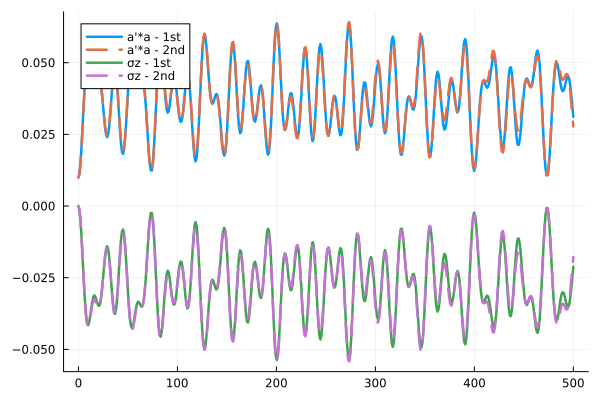

In [81]:
plot(t_list, abs.(sol_1[a'*a]), lw=2.5, label="a'*a - 1st")
plot!(t_list, abs.(sol_2[a'*a]), lw=2.5, ls=:dash, label="a'*a - 2nd")
plot!(t_list, real.(1 .- sol_1[σ(:e,:e)]), lw=2.5, label="σz - 1st")
plot!(t_list, real.(1 .- sol_2[σ(:e,:e)]), lw=2.5, ls=:dash, label="σz - 2nd")

#plot!(t_list, imag.(sol[a*σ(:e,:e)]), lw=2.5, label="a*σz")